# Kalman Sandbox

Testing the basic Kalman filter for linear system where:

$y_t = \alpha + \beta_t x_t + \epsilon_t$

$\beta_t = \bf F \beta_{t-1}$

We will simulate $x_t$ to have normal variances $N(1, 10)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from filterpy.kalman import KalmanFilter

In [2]:
betas1 = [3 for i in range(50)] + [6 for i in range(50)]
x = [np.random.normal(1, 10) for i in range(100)]
y1 = np.array(x) * np.array(betas1) + np.array([np.random.normal(0, 0.1) for i in range(len(x))])

In [3]:
class KF:
    def __init__(self, x0, lags=0):
        self.lags = lags
        kf = KalmanFilter(dim_x=lags+2, dim_z=lags+2)
        kf.x = x0
        kf.Q = 100
        kf.P = np.diag([1, 100])
        kf.R = np.diag([1, 10])
        kf.F = np.array([[1,1], [1,1]])
        self.kf = kf
        self.xs = {i: [] for i in range(self.lags+2)}
    
    def run(self, y_col, x_col, df):        
        # run filter
        for i in range(1, len(df)):
            self.kf.predict()
            self.kf.H = np.array([[1] + [df.shift(j).iloc[i][f'{x_col}'] for j in range(self.lags+1)], 
                                 [1] + [df.shift(j).iloc[i-1][f'{x_col}'] for j in range(self.lags+1)]]) # update H with fresh values
            self.kf.update(np.array([df.iloc[i][f'{y_col}'], df.iloc[i-1][f'{y_col}']]))
            for j in range(self.lags+2):
                self.xs[j].append(self.kf.x[j])
                
        return pd.DataFrame(self.xs, index=range(1, len(df)))

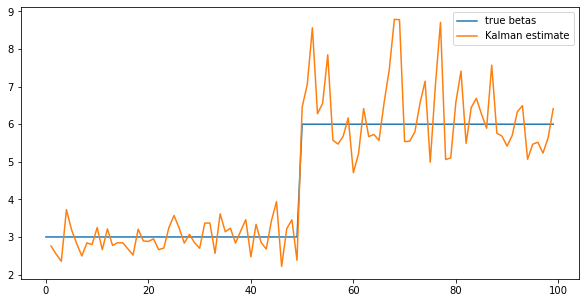

In [4]:
x0 = np.array([1, 5])
kf = KF(x0).run('y', 'x', pd.DataFrame({'y': y1, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas1, label='true betas')
plt.plot(kf[1], label='Kalman estimate')
plt.legend()

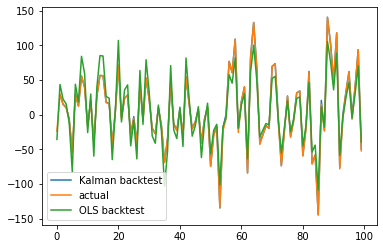

In [5]:
backtest_k = kf[0] + kf[1] * np.array(x[1:])
ols = sm.OLS(y1, 
             sm.add_constant(x)).fit().params
backtest_o = ols[0] + ols[1] * np.array(x)
plt.plot(backtest_k, label='Kalman backtest')
plt.plot(y1, label='actual') # no need to cut y1 length because kf series starts from 1
plt.plot(backtest_o, label='OLS backtest')
plt.legend()

In [6]:
rmse_ols = np.sqrt(np.sum((y1 - backtest_o) ** 2) / len(backtest_o))
rmse_kalman = np.sqrt(np.sum((y1[1:] - backtest_k) ** 2) / len(backtest_k))
print(f'RMSE OLS: {rmse_ols}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE OLS: 16.46363795975064
RMSE Kalman: 1.8907828359521535


In [7]:
betas2 = [i * np.random.normal(1, 10) for i in range(100)]
y2 = np.array(x) * np.array(betas2) + np.array([np.random.normal(0, 10) for i in range(len(x))])

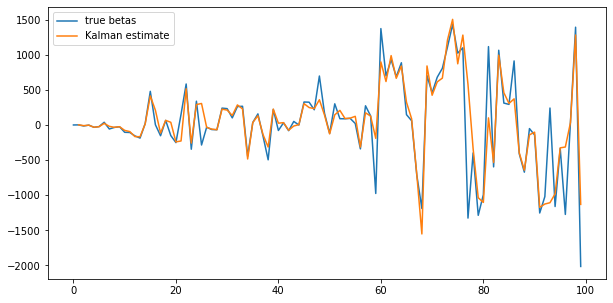

In [8]:
kf2 = KF(x0).run('y', 'x', pd.DataFrame({'y': y2, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas2, label='true betas')
plt.plot(kf2[1], label='Kalman estimate')
plt.legend()

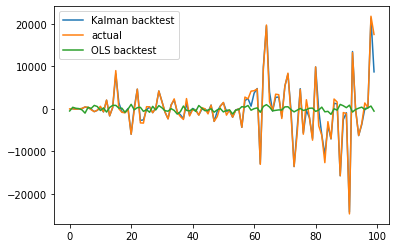

In [9]:
backtest_k = kf2[0] + kf2[1] * np.array(x[1:])
ols = sm.OLS(y2, 
             sm.add_constant(x)).fit().params

backtest_o = ols[0] + ols[1] * np.array(x)
plt.plot(backtest_k, label='Kalman backtest')
plt.plot(y2, label='actual') # no need to cut y1 length because kf series starts from 1
plt.plot(backtest_o, label='OLS backtest')
plt.legend()

In [10]:
rmse_ols = np.sqrt(np.sum((y2 - backtest_o) ** 2) / len(backtest_o))
rmse_kalman = np.sqrt(np.sum((y2[1:] - backtest_k) ** 2) / len(backtest_k))
print(f'RMSE OLS: {rmse_ols}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE OLS: 6063.664054067493
RMSE Kalman: 1190.6050711066093


Finally we simulate a trend.

In [11]:
betas3 = [100 + i + np.random.normal(1, 10) for i in range(100)]
y3 = np.array(x) * np.array(betas3) + np.array([np.random.normal(0, 10) for i in range(len(x))])

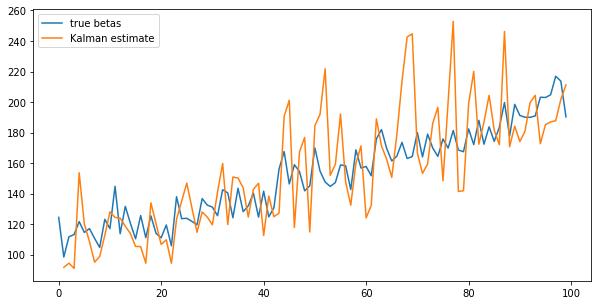

In [12]:
kf3 = KF(x0).run('y', 'x', pd.DataFrame({'y': y3, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas3, label='true betas')
plt.plot(kf3[1], label='Kalman estimate')
plt.legend()

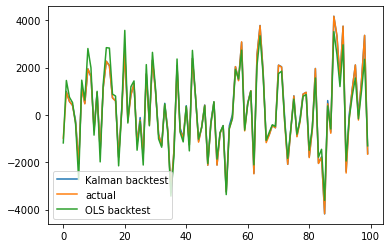

In [13]:
backtest_k = kf3[0] + kf3[1] * np.array(x[1:])
ols = sm.OLS(y3, 
             sm.add_constant(x)).fit().params

backtest_o = ols[0] + ols[1] * np.array(x)
plt.plot(backtest_k, label='Kalman backtest')
plt.plot(y3, label='actual') # no need to cut y1 length because kf series starts from 1
plt.plot(backtest_o, label='OLS backtest')
plt.legend()

In [14]:
rmse_ols = np.sqrt(np.sum((y1 - backtest_o) ** 2) / len(backtest_o))
rmse_kalman = np.sqrt(np.sum((y1[1:] - backtest_k) ** 2) / len(backtest_k))
print(f'RMSE OLS: {rmse_ols}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE OLS: 1598.2909127150608
RMSE Kalman: 1629.0120456984264


It seems that the short term rolling window is far more prone to noise, and a longer-term measurement sample allows a better fit to the underlying trend.